In [3]:
# Load the data
import pandas as pd
import json

data_frame_wcus = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wcus-db1.csv"))
data_frame_wus2_db1 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db1.csv"))
data_frame_wus2_db2 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db2.csv"))
data_frame_wus2_db3 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db3.csv"))

data_frame = pd.concat([data_frame_wcus, data_frame_wus2_db1, data_frame_wus2_db2, data_frame_wus2_db3], sort=False)

data_frame.reset_index()

,index,2,138,748,65616,WS-2015-0042,v2:b70509f9-a16c-4c1f-94e5-552026852631,1,12,"{""WhiteSource"":{""Url"":""https://github.com/fabric/fabric/issues/1341""}}",...,v6:315e89fa5a2042f08dc1671e845bcbd2,0,"{""WhiteSource"":{""Url"":""https://vuln.whitesourcesoftware.com/vulnerability/CVE-2020-35908""}}",4085,1743,5998771,CVE-2019-18413,v6:9c55c248e54f40dd8d631bcb6d1342d8,3,"{""GitHubAdvisories"":{""Url"":""https://nvd.nist.gov/vuln/detail/CVE-2019-18413""},""WhiteSource"":{""Url"":""https://vuln.whitesourcesoftware.com/vulnerability/CVE-2019-18413""}}"
0,0,4.0,11.0,7.0,97799.0,CVE-2022-39353,v6:e3089068ab2344299bbc0d5427fc5b86,3.0,2.0,"{""GitHubAdvisories"":{""Url"":""https://github.com...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4.0,11.0,7.0,40320.0,CVE-2017-12964,v6:dc35c9c8bb76489e8c86bf112a93d03c,2.0,2.0,"{""WhiteSource"":{""Url"":""https://vuln.whitesourc...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4.0,11.0,7.0,303.0,CVE-2015-8855,v2:e40eaeec-f67b-4f36-8607-440202e3f8ec,2.0,2.0,"{""GitHubAdvisories"":{""Url"":""https://nvd.nist.g...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4.0,11.0,7.0,2011.0,CVE-2017-16026,v2:fff06527-9f4b-4bf4-9e36-a70e9908df6b,1.0,2.0,"{""GitHubAdvisories"":{""Url"":""https://nvd.nist.g...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,11.0,7.0,48874.0,CVE-2020-7746,v6:f31efae2c56943e39b398b81c4f93205,2.0,2.0,"{""GitHubAdvisories"":{""Url"":""https://nvd.nist.g...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19633,2514,9.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,161654.0,185959.0,5600566.0,CVE-2019-14562,v6:d95ab93c404948a68d395a0669e22b8f,0.0,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
19634,2515,9.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,161654.0,185959.0,5600569.0,CVE-2021-28210,v6:4336276a04ed417d8652286035fad0c8,1.0,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
19635,2516,9.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,161654.0,185959.0,8047656.0,CVE-2021-38578,v6:7e040ad399634d3d95a951bf3356fbd3,2.0,"{""WhiteSource"":{""Url"":""https://vuln.whitesourc..."
19636,2517,9.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,161654.0,185959.0,6707960.0,CVE-2021-38577,v6:22ea0bba55f54af0b4061accc30e5eba,2.0,"{""WhiteSource"":{""Url"":""https://vuln.whitesourc..."


In [4]:
# remove duplicate alertkey
data_frame = data_frame.drop_duplicates(subset=['alertkey'], keep='first')

KeyError: Index(['alertkey'], dtype='object')

In [ ]:
# deconstruct the data to create an entry per source
sources_df = pd.DataFrame({'alertkey':[],
                            'source': [],
                            'url':[]})

# Deconstructing the sources data
# to create one source per row
for index, row in data_frame.iterrows():
    json_sources = row['sources']
    sources = json.loads(json_sources)
    for key in sources.keys():
        if key != "TwC":
            sources_df = pd.concat([sources_df, pd.DataFrame({'alertkey': row['alertkey'], 'source': key, 'url': sources[key]})])

data_frame.drop('sources', axis=1, inplace=True)
data_frame = data_frame.merge(sources_df, left_on='alertkey', right_on='alertkey')

<AxesSubplot:ylabel='alertkey'>

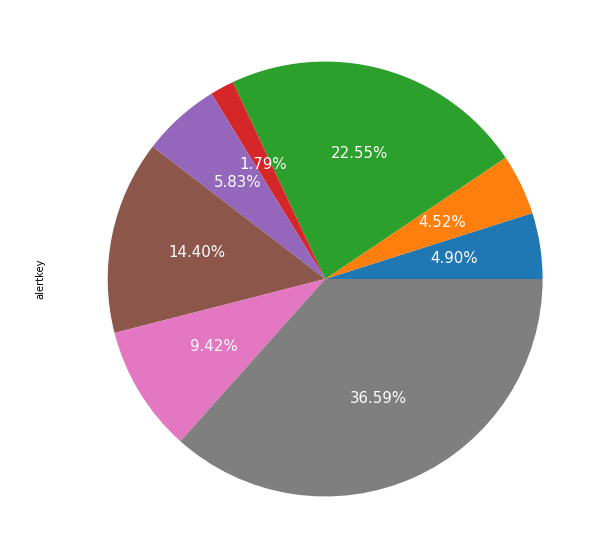

In [ ]:
# Alerts distribution by data providers
data_frame[data_frame['component_type'] != 9].groupby('source')['alertkey'] .count() .plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10), autopct='%1.2f%%')

In [ ]:

# components types that support security vulnerabilities
ct_dict = { "component_type_id" : [1,2,3,6,7,8,9,10,12,13,14],
            "component_type_name" : [ "NuGet", "Npm", "Maven", "RubyGems", "Cargo", "Pip", "File", "Go", "Pod", "Linux", "Conda"]
}
component_types = pd.DataFrame(ct_dict)

In [ ]:

# alert severities
sev_dict = { "severity_id" : [0,1,2,3],
            "severity_name" : ["Low", "Medium", "High", "Critical"]
}
severities = pd.DataFrame(sev_dict)

In [ ]:
# Percentage of alerts that are only found in GA
ga_alerts = data_frame[data_frame['source'] == 'GitHubAdvisories']
no_ga_alerts = data_frame[data_frame['source'] != 'GitHubAdvisories']
# some alerts are found in multiple sources, doing this we guarantee that we are going to get
# only the alerts that have only one source and that source is GithubAdvisories
only_ga = ga_alerts[~ga_alerts['alertkey'].isin(no_ga_alerts['alertkey'])]
(only_ga.shape[0]/data_frame.shape[0])*100

6.590986106404609

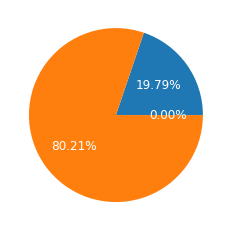

In [ ]:
# Distribution of vulnerabilities ids from alerts found only by GA

from matplotlib import pyplot as plt

ghsa = only_ga.title.str.startswith('GHSA', na=False).sum()
cve = only_ga.title.str.startswith('CVE', na=False).sum()
other = only_ga.shape[0] - ghsa - cve

plt.pie([ghsa, cve, other], labels=["GHSA", "CVE", "Other"], textprops={'color':"white", 'fontsize':12}, autopct='%1.2f%%')
plt.show()

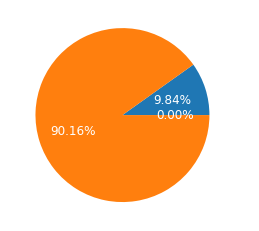

In [ ]:
# Distribution of vulnerabilities ids for alerts that were only found by WS

from matplotlib import pyplot as plt

ws = only_ws.title.str.startswith('WS', na=False).sum()
cve = only_ws.title.str.startswith('CVE', na=False).sum()
other = only_ws.shape[0] - ws - cve

plt.pie([ws, cve, other], labels=["WS", "CVE", "Other"], textprops={'color':"white", 'fontsize':12}, autopct='%1.2f%%')
plt.show()

<AxesSubplot:ylabel='alertkey'>

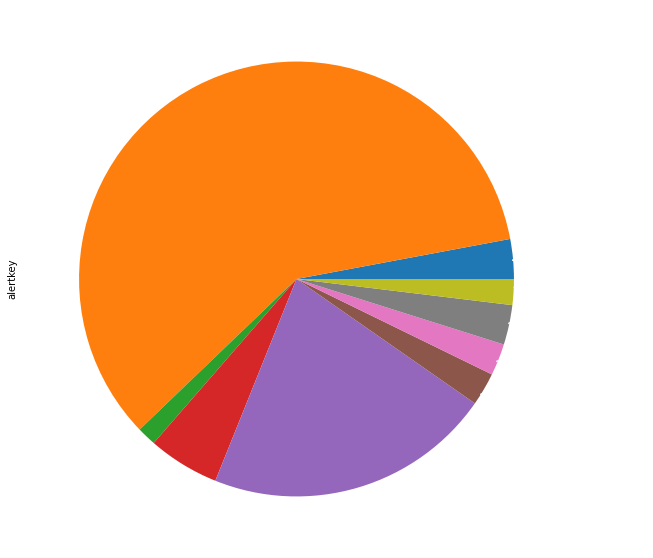

In [ ]:
# Component types of the CVE alerts that where only found by WS

ws_cve_alerts = only_ws[only_ws.title.str.startswith('CVE', na=False)]
ws_cve_alerts = ws_cve_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
ws_cve_alerts.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24)

In [ ]:
# Alerts for a specific component type

ws_cve_alerts = only_ws[only_ws.title.str.startswith('CVE', na=False)]
ws_cve_alerts = ws_cve_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
ws_cve_alerts[ws_cve_alerts.component_type_name == "Maven"]

,partitionid,dataspaceid,repositoryid,alertid,title,alertkey,severity,component_type,source,url,component_type_id,component_type_name
1422,4,11,269,79038,CVE-2020-13936,v6:f1df5f3f7e124bf8bf169434206c129c,3,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1423,4,11,269,75676,CVE-2021-38153,v6:6188cc5cf91c40038219f3de60967ad9,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1424,4,11,269,78196,CVE-2021-44548,v6:662177f0c70b425db259dd6915633e9b,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1425,4,11,269,72982,CVE-2021-32827,v6:468db02f3db44d169341187a63b21fc2,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1426,4,11,269,62076,CVE-2013-2192,v6:e18de5a2eced4060a839b8199c64f06a,0,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
...,...,...,...,...,...,...,...,...,...,...,...,...
1852,37650,277162,195794,7004586,CVE-2020-7021,v6:f5cc055aab23497886faec11253270fa,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1853,38746,283804,197639,7056651,CVE-2020-10693,v6:d425e44e1d7c4b84a2040063a7d63e9c,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1854,38746,283804,197639,7056669,CVE-2018-11040,v2:b81ee1e5-cc9d-40a3-92d3-e7017d8753dd,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven
1855,38746,283804,197639,7056639,CVE-2020-2875,v6:45e674ba704c4afb9b20a78df6dca06c,1,3,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,3,Maven


In [ ]:
# percentage of alerts are only covered by WhiteSource
ws_alerts = data_frame[data_frame['source'] == 'WhiteSource']
no_ws_alerts = data_frame[data_frame['source'] != 'WhiteSource']
only_ws = ws_alerts[~ws_alerts['alertkey'].isin(no_ws_alerts['alertkey'])]
(only_ws.shape[0]/data_frame.shape[0]) * 100

42.019654354456115

In [ ]:
# percentage of whitesource alerts that are also found in github advisories
ws_alerts_covered_by_ga = ga_alerts[ga_alerts["alertkey"].isin(ws_alerts['alertkey'])]
(ws_alerts_covered_by_ga.shape[0]/ws_alerts.shape[0]) * 100

19.60594315245478

In [ ]:
# percentage of whitesource alerts that are also found in github advisories considering only component types that both providers support
ws_alerts_covered_by_ga = ga_alerts[ga_alerts["alertkey"].isin(ws_alerts['alertkey'])]
ws_same_ct_alerts = ws_alerts[ws_alerts.component_type.isin(ga_alerts.component_type)]
(ws_alerts_covered_by_ga.shape[0]/ws_same_ct_alerts.shape[0]) * 100

44.017403915881076

In [ ]:
# Components Types that are only covered by WS
ct_only_covered_ws = ows_ct_data[~ows_ct_data["component_type"].isin(no_ws_alerts["component_type"])]["component_type"]
component_types[component_types["component_type_id"].isin(ct_only_covered_ws)]


,component_type_id,component_type_name
4,7,Cargo
6,9,File
7,10,Go


In [ ]:
# Component Types of the alerts that were reported only by WS
ows_ct_data = only_ws.merge(component_types, left_on='component_type', right_on='component_type_id')

ows_ct_data.shape

#ows_ct_data.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
#labeldistance=1.24)

(2480, 12)

<AxesSubplot:ylabel='alertkey'>

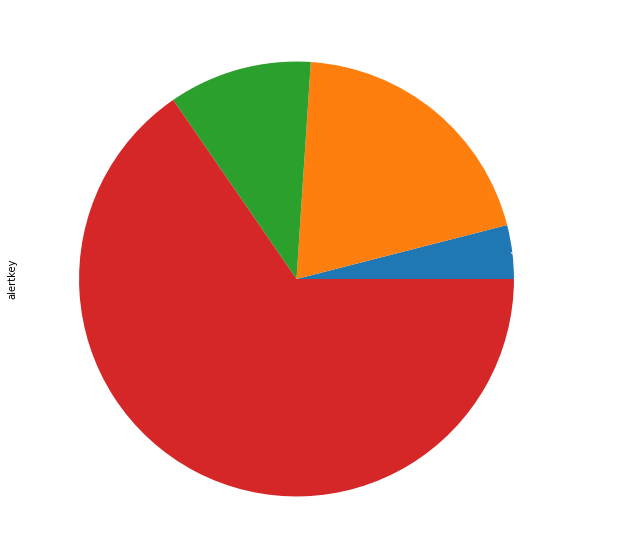

In [ ]:
# Severity of the alerts that were reported only by WS
ows_sev_data = only_ws.merge(severities, left_on='severity', right_on='severity_id')
ows_sev_data.groupby('severity_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24)

<AxesSubplot:ylabel='alertkey'>

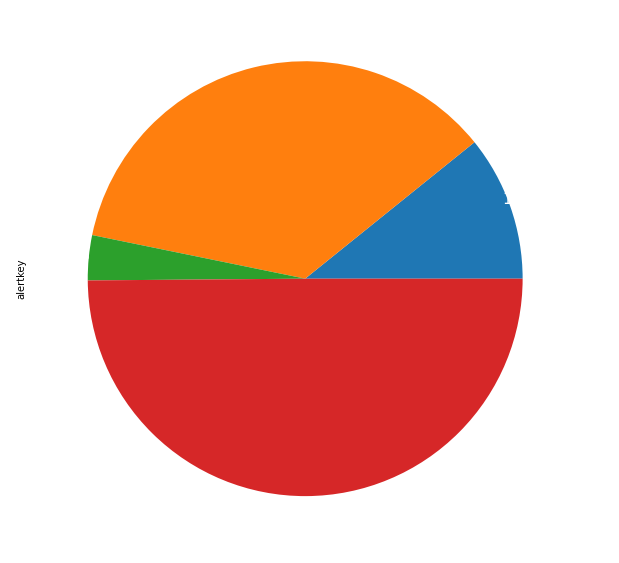

In [ ]:
# Severity of the alerts that were reported only by WS
oga_sev_data = only_ga.merge(severities, left_on='severity', right_on='severity_id')
oga_sev_data.groupby('severity_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24)

<AxesSubplot:ylabel='alertkey'>

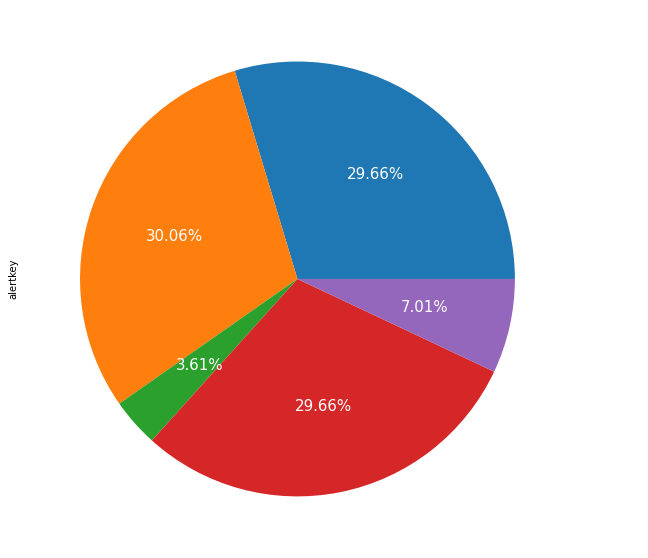

In [ ]:
# Component Types of the alerts that were reported only by Github Advisories
oga_ct_data = ga_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
oga_ct_data.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', labeldistance= 1.24)

In [ ]:
# components types that are covered
component_types[ component_types["component_type_id"].isin(ws_alerts_covered_by_ga["component_type"])]

,component_type_id,component_type_name
0,1,NuGet
1,2,Npm
2,3,Maven
3,6,RubyGems
5,8,Pip


In [ ]:
# Severities of the alerts that are only covered by WS
only_ws.groupby('severity')['alertkey'].count()

severity
0     264
1    1622
2     495
3      99
Name: alertkey, dtype: int64

In [ ]:
# What components types were not found in alerts from github advisories

component_types[~component_types["component_type_id"].isin(ga_alerts['component_type'])]["component_type_name"]




4     Cargo
6      File
7        Go
8       Pod
9     Linux
10    Conda
Name: component_type_name, dtype: object

In [ ]:

data_frame[data_frame["component_type"] == 13].groupby("source")["alertkey"].count()

source
Alpine         217
Debian         200
OssIndex       258
UbuntuCve      637
WhiteSource    130
Name: alertkey, dtype: int64